In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- Dense Layer inside a Dense Block ---
class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(DenseLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, 4 * growth_rate, kernel_size=1, bias=False)

        self.bn2 = nn.BatchNorm2d(4 * growth_rate)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(self.relu1(self.bn1(x)))
        out = self.conv2(self.relu2(self.bn2(out)))
        out = torch.cat([x, out], 1)  # Concatenate input and output
        return out

In [2]:
# --- Dense Block ---
class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        layers = []
        for i in range(num_layers):
            layers.append(DenseLayer(in_channels + i * growth_rate, growth_rate))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

In [3]:
# --- Transition Layer ---
class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.pool = nn.AvgPool2d(2, stride=2)

    def forward(self, x):
        out = self.conv(self.relu(self.bn(x)))
        out = self.pool(out)
        return out

In [4]:

class DenseNet121(nn.Module):
    def __init__(self, growth_rate=32, num_classes=1000):
        super(DenseNet121, self).__init__()

        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(3, stride=2, padding=1)

        # Dense Blocks configuration for DenseNet-121
        block_layers = [6, 12, 24, 16]  # number of layers per dense block
        num_channels = 64

        # Dense Block 1
        self.block1 = DenseBlock(block_layers[0], num_channels, growth_rate)
        num_channels += block_layers[0] * growth_rate
        self.trans1 = TransitionLayer(num_channels, num_channels // 2)
        num_channels = num_channels // 2

        # Dense Block 2
        self.block2 = DenseBlock(block_layers[1], num_channels, growth_rate)
        num_channels += block_layers[1] * growth_rate
        self.trans2 = TransitionLayer(num_channels, num_channels // 2)
        num_channels = num_channels // 2

        # Dense Block 3
        self.block3 = DenseBlock(block_layers[2], num_channels, growth_rate)
        num_channels += block_layers[2] * growth_rate
        self.trans3 = TransitionLayer(num_channels, num_channels // 2)
        num_channels = num_channels // 2

        # Dense Block 4
        self.block4 = DenseBlock(block_layers[3], num_channels, growth_rate)
        num_channels += block_layers[3] * growth_rate

        # Classification layer
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(num_channels, num_classes)

    def forward(self, x):
        out = self.pool1(self.relu(self.bn1(self.conv1(x))))

        out = self.trans1(self.block1(out))
        out = self.trans2(self.block2(out))
        out = self.trans3(self.block3(out))
        out = self.block4(out)

        out = self.avgpool(self.relu(self.bn2(out)))
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

"""
# --- Test DenseNet121 ---
if __name__ == "__main__":
    model = DenseNet121(num_classes=10)  # example: 10 classes
    x = torch.randn(1, 3, 224, 224)     # example input
    y = model(x)
    print(y.shape)  # should print torch.Size([1, 10])"""

'\n# --- Test DenseNet121 ---\nif __name__ == "__main__":\n    model = DenseNet121(num_classes=10)  # example: 10 classes\n    x = torch.randn(1, 3, 224, 224)     # example input\n    y = model(x)\n    print(y.shape)  # should print torch.Size([1, 10])'

In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_data = "/Users/benjaminbrooke/.cache/kagglehub/datasets/sriramr/apples-bananas-oranges/versions/1/original_data_set/train_data"

transform = transforms.Compose([transforms.Resize(size=(244,244)),
                                transforms.ToTensor()])

data_train_loader = datasets.ImageFolder(train_data,transform=transform)

train_loader = DataLoader(data_train_loader, batch_size=20, shuffle=True)

In [6]:
model_dense_net_121 = DenseNet121(num_classes=6)

In [7]:
optimizer = torch.optim.Adam(model_dense_net_121.parameters(), lr = 0.01)

In [8]:
loss_fn = nn.CrossEntropyLoss()

In [9]:
from tqdm.notebook import tqdm

epoch = 3

model_dense_net_121.train()

loss_list = []
acc_list = []


for epoch in tqdm(range(epoch), desc="Epochs"):

    for X_train, y_train in tqdm(train_loader):

        optimizer.zero_grad()

        y_pred = model_dense_net_121(X_train)

        loss = loss_fn(y_pred,y_train)

        loss.backward()

        optimizer.step()

        preds = y_pred.argmax(dim=1)

        acc = (preds == y_train).float().mean().item()

        acc_list.append(acc)
        loss_list.append(loss.item())

Epochs:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

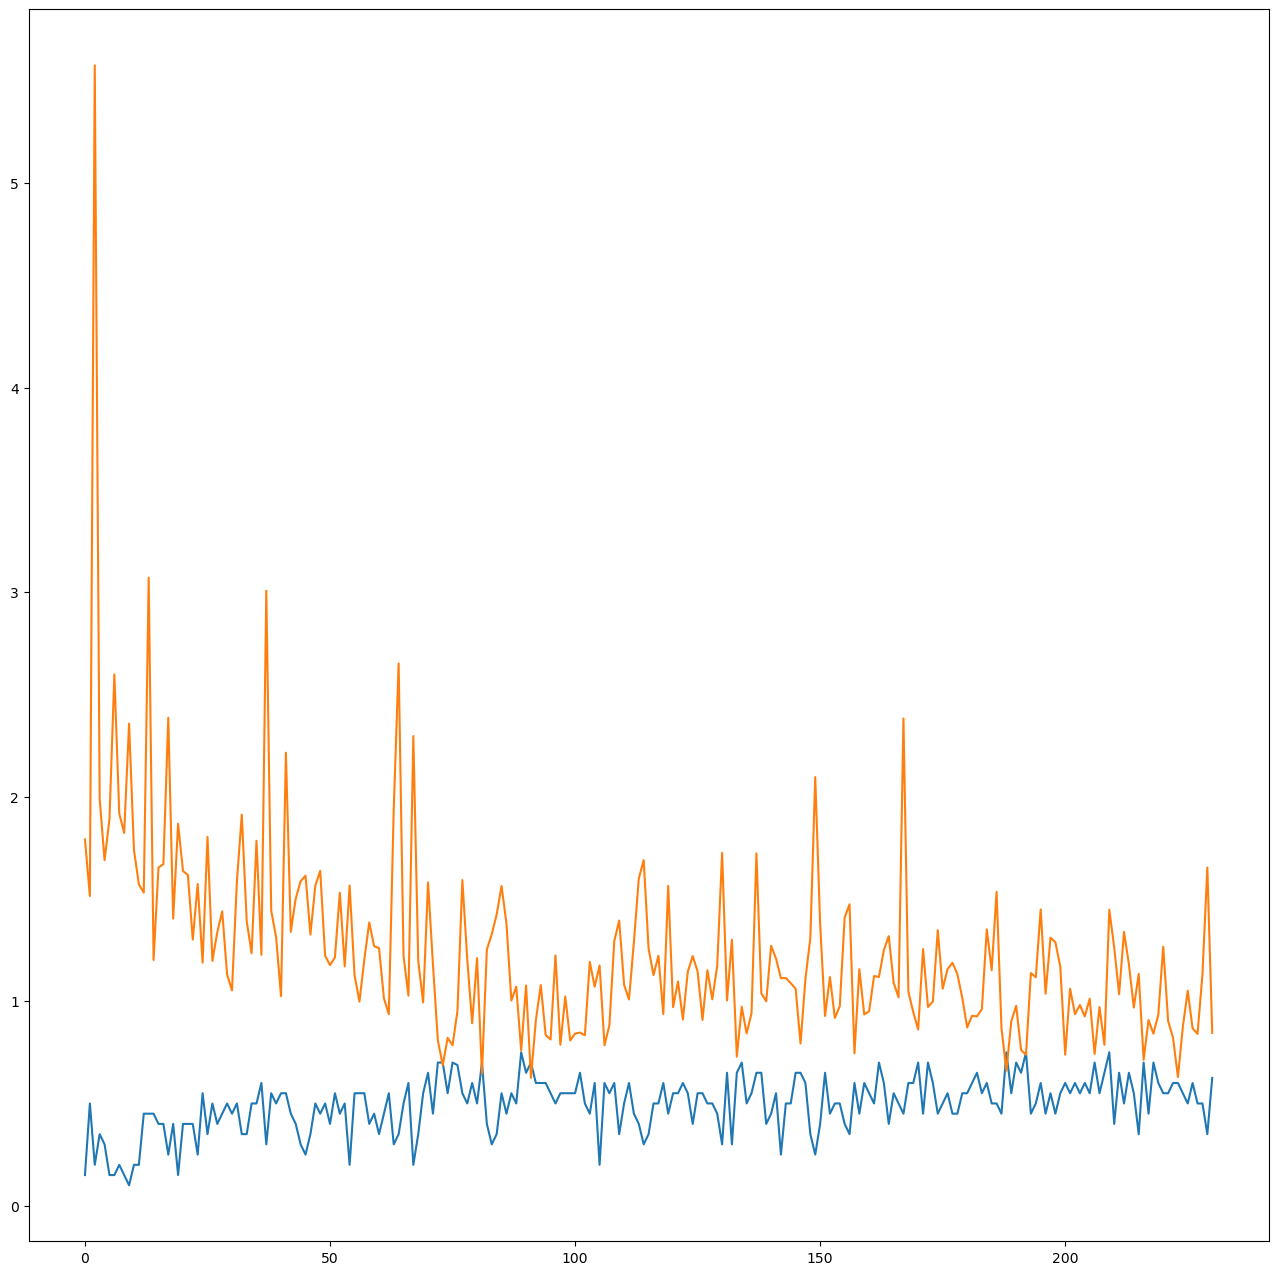

In [12]:
import matplotlib.pyplot as plt

x = range(len(loss_list))

plt.figure(figsize=(16,16))

plt.plot(x,acc_list)
plt.plot(x,loss_list)

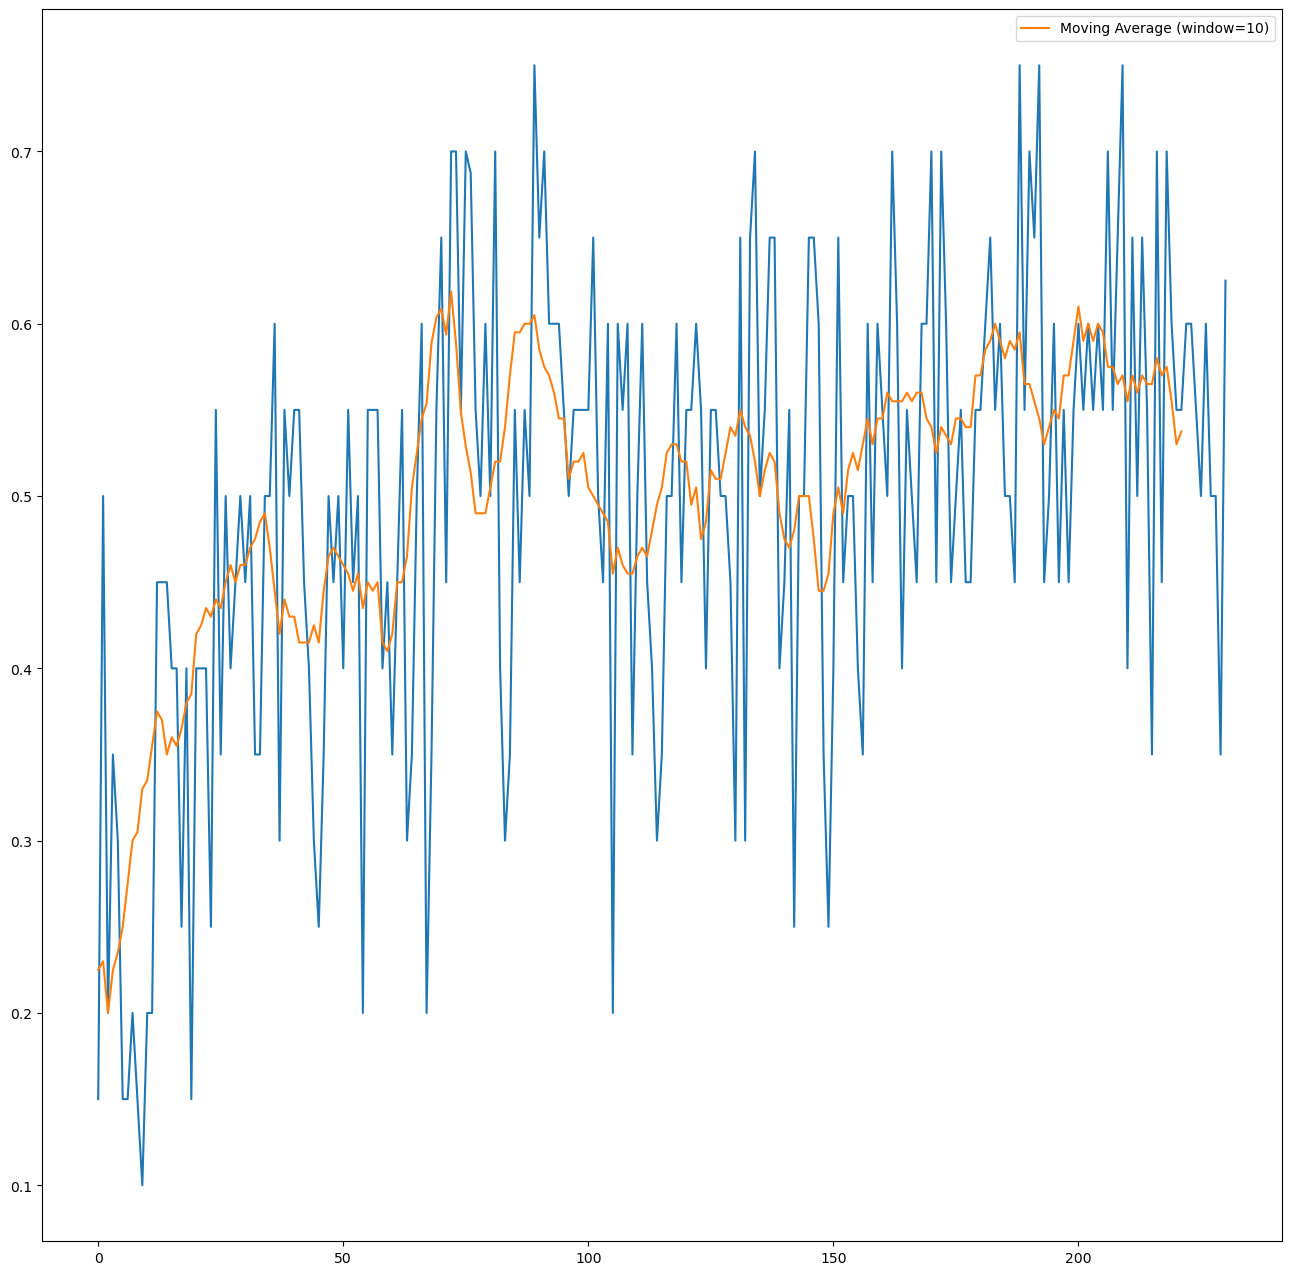

In [15]:

import numpy as np


x = range(len(loss_list))

plt1 = plt

plt1.figure(figsize=(16,16))

plt1.plot(x,acc_list)

# --- Moving Average (window=10) ---
window = 10
smooth = np.convolve(acc_list, np.ones(window)/window, mode='valid')
plt.plot(range(len(smooth)), smooth, label="Moving Average (window=10)")

plt.legend()
plt.show()